In [1]:
from astropy.table import Table
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn import metrics
from sklearn.metrics import silhouette_samples
%matplotlib inline

In [2]:
cd ../Code

/Users/pauline/research_proj/m83_clustering/Code


In [3]:
alldat = Table.read('data_v4.txt',format='ascii.commented_header')

In [4]:
# make a list of the uncertainty column names
unclist = []
for coln in alldat.colnames:
    if 'mag05' in coln and '_unc' in coln:
        unclist.append(coln)
        
# make a list of the photometry columns
photlist = []
for coln in alldat.colnames:
    if 'mag05' in coln and '_unc' not in coln:
        photlist.append(coln)

In [5]:
# mask for good data
msklist = []
for i,unc in enumerate(unclist):
    msk = np.logical_and(alldat[photlist[i]]!=-99,np.logical_and(alldat[unc]<0.2, alldat[unc]>0))
    msklist.append(msk)

In [16]:
for i,m in enumerate(msklist):
    print(unclist[i],m.sum())

('mag05_225_unc', 15011)
('mag05_336_unc', 34129)
('mag05_373_unc', 8878)
('mag05_438_unc', 48858)
('mag05_487_unc', 13335)
('mag05_502_unc', 14654)
('mag05_555_unc', 65652)
('mag05_657_unc', 23939)
('mag05_673_unc', 25295)
('mag05_814_unc', 59600)


In [6]:
# combine the masks
cmask=np.column_stack(msklist).all(axis=1)

In [18]:
# how many objects have all the data?
cmask.sum()

6306

In [7]:
# generate some more usefully named masks
allgood = cmask

In [8]:
notallgood = np.logical_not(cmask)
goodvi = np.logical_and(msklist[6],msklist[9])
goodub = np.logical_and(msklist[1],msklist[3])

(29, 18)

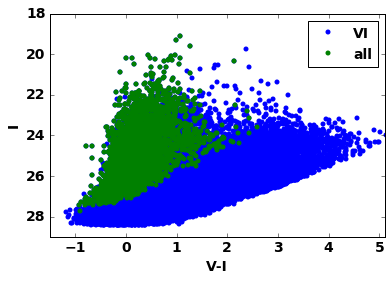

In [23]:
# compare the 'allgood' data to VI-good only
f,ax=plt.subplots()
ax.plot(alldat['mag05_555'][goodvi]-alldat['mag05_814'][goodvi],alldat['mag05_814'][goodvi],marker='.',label='VI')
ax.plot(alldat['mag05_555'][allgood]-alldat['mag05_814'][allgood],alldat['mag05_814'][allgood],marker='.',label='all')
ax.set_xlabel('V-I')
ax.set_ylabel('I')
ax.legend()
ax.set_xlim(-1.5,5.1)
ax.set_ylim(29,18)

(30, 18)

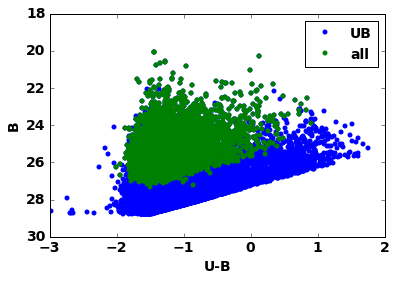

In [25]:
# compare the 'allgood' data to UB-good only
f,ax=plt.subplots()
ax.plot(alldat['mag05_336'][goodub]-alldat['mag05_438'][goodub],alldat['mag05_438'][goodub],marker='.',label='UB')
ax.plot(alldat['mag05_336'][allgood]-alldat['mag05_438'][allgood],alldat['mag05_438'][allgood],marker='.',label='all')
ax.set_xlabel('U-B')
ax.set_ylabel('B')
ax.legend()
ax.set_xlim(-3,2)
ax.set_ylim(30,18)

In [37]:
# generate list of colours for good data, relative to F814W
col_dat = np.array([alldat[p][allgood]-alldat['mag05_814'][allgood] for p in photlist]).T

In [38]:
col_dat

array([[-0.932, -1.058, -0.833, ..., -0.397, -0.118,  0.   ],
       [-2.305, -1.813, -1.544, ..., -1.029, -0.17 ,  0.   ],
       [-1.633, -1.442, -0.787, ..., -0.762,  0.154,  0.   ],
       ..., 
       [-1.59 , -1.487, -1.223, ..., -1.285, -0.373,  0.   ],
       [-1.019, -1.358, -0.832, ..., -0.387, -0.143,  0.   ],
       [ 1.292, -0.147, -0.126, ..., -0.114,  0.047,  0.   ]])

In [39]:
km_new = KMeans(4, init='random')
km_new.fit(col_dat)
labels = km_new.labels_

In [40]:
newcens = km_new.cluster_centers_

array([[ 1.56232735,  0.83286996,  0.82771076,  1.40387668,  0.89916592,
         1.13153139,  1.00288789, -0.11072646,  0.49618161,  0.        ],
       [-1.98523637, -1.72340669, -1.3213267 , -0.22449184, -0.48597493,
        -0.16549662, -0.15158496, -1.08016116, -0.12596379,  0.        ],
       [-0.99639176, -1.12172856, -0.84635576,  0.1553406 , -0.16621554,
         0.13393889,  0.11728233, -0.89737281,  0.02471388,  0.        ],
       [ 0.26728074, -0.32598139, -0.26297492,  0.56221521,  0.16331311,
         0.43956796,  0.3889199 , -0.60526052,  0.14197006,  0.        ]])

In [41]:
# turn mags into flux
flux_cens = 10**(-0.4*(newcens))
flux_cens_narrow = 10**(-0.4*(newcens[:,[2,4,5,7,8]]))

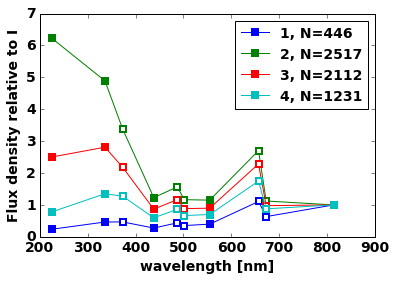

In [44]:
# plot the group centres as "SEDs"
wave_all = np.array((225,336,373,438,487,502,555,657,673,814))
wave_narrow = np.array((373,487,502,657,673))
f,ax = plt.subplots()
for i in range(0,4):
    pt_in_grp = len(col_dat[labels==i])
    legend_text = '%1d, N=%d' % (i+1,pt_in_grp)
    ax.plot(wave_all,flux_cens[i],label=legend_text,ms=8,ls="solid",mec="None")
    ax.plot(wave_narrow,flux_cens_narrow[i],ms=4,color="white",mec="None")
ax.legend()
ax.set_xlabel('wavelength [nm]')
ax.set_ylabel('Flux density relative to I')


In [43]:
for i in range(0,4):
    print(len(col_dat[labels==i]))

446
2517
2112
1231


In [29]:
def cluster_all_colours(data, photlist, anchor='mag05_555',nclust=4,anchor_lab='V'):
    col_dat = np.array([alldat[p][allgood]-alldat[anchor][allgood] for p in photlist]).T
    km_new = KMeans(nclust, init='random')
    km_new.fit(col_dat)
    labels = km_new.labels_
    newcens = km_new.cluster_centers_
    # turn mags into flux
    flux_cens = 10**(-0.4*(newcens))
    flux_cens_narrow = 10**(-0.4*(newcens[:,[2,4,5,7,8]]))
    # plot the group centres as "SEDs"
    wave_all = np.array((225,336,373,438,487,502,555,657,673,814))
    wave_narrow = np.array((373,487,502,657,673))
    f,ax = plt.subplots()
    for i in range(0,nclust):
        pt_in_grp = len(col_dat[labels==i])
        legend_text = '%1d, N=%d' % (i+1,pt_in_grp)
        ax.plot(wave_all,flux_cens[i],label=legend_text,ms=8,ls="solid",mec="None")
        ax.plot(wave_narrow,flux_cens_narrow[i],ms=4,color="white",mec="None")
    ax.set_ylim(0,9)
    ax.legend(ncol=2)
    ax.set_xlabel('Filter wavelength [nm]')
    ax.set_ylabel('Flux density relative to '+anchor_lab)
    f.savefig('/Users/pauline/Desktop/fig1.png',dpi=300)
    
    f,ax = plt.subplots()
    for i in range(0,nclust):
        pt_in_grp = len(col_dat[labels==i])
        legend_text = '%1d, N=%d' % (i+1,pt_in_grp)
        ax.plot(alldat['mag05_555'][allgood][labels==i]-alldat['mag05_814'][allgood][labels==i],
                alldat['mag05_336'][allgood][labels==i]-alldat['mag05_438'][allgood][labels==i],
                label=legend_text,ms=3,mec="None")
    ax.set_ylim(-2.5,1.5)
    ax.legend(ncol=2)
    ax.set_xlabel('V-I')
    ax.set_ylabel('U-B')
    f.savefig('/Users/pauline/Desktop/fig2.png',dpi=300)
    return    

In [34]:
def compute_scores(data, photlist, anchor='mag05_555'):
    col_dat = np.array([alldat[p][allgood]-alldat[anchor][allgood] for p in photlist]).T
    for nclust in range(3,9):
        print "N: {}".format(nclust)
        km_new = KMeans(nclust, init='random')
        km_new.fit(col_dat)
        labels = km_new.labels_
        newcens = km_new.cluster_centers_
        score = metrics.silhouette_score(col_dat, labels)
        sample_score = silhouette_samples(col_dat, labels)
        print "N: {} Score: {}".format(nclust,score)
    return

In [35]:
#this took quite a while to run..
compute_scores(alldat[allgood],photlist,'mag05_555')

N: 3
N: 3 Score: 0.314958851863
N: 4
N: 4 Score: 0.328367925675
N: 5
N: 5 Score: 0.249200161083
N: 6
N: 6 Score: 0.272372352114
N: 7
N: 7 Score: 0.212408944033
N: 8
N: 8 Score: 0.20791202567


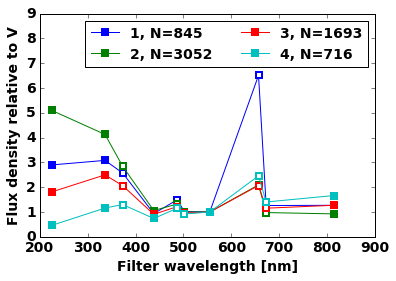

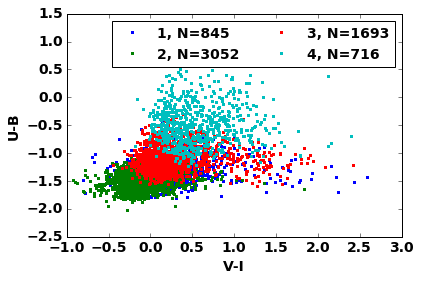

In [37]:
cluster_all_colours(alldat[allgood],photlist,'mag05_555')

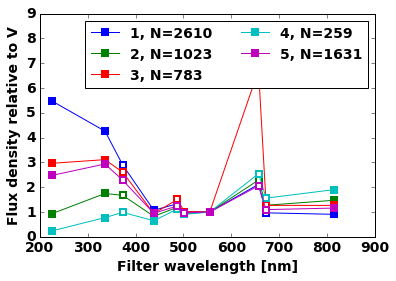

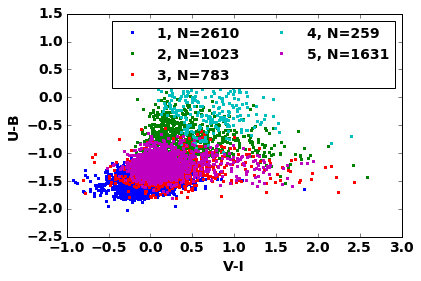

In [36]:
cluster_all_colours(alldat[allgood],photlist,'mag05_555',nclust=5)

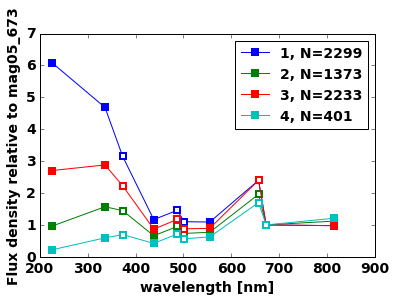

In [25]:
cluster_all_colours(alldat[allgood],photlist,'mag05_673')

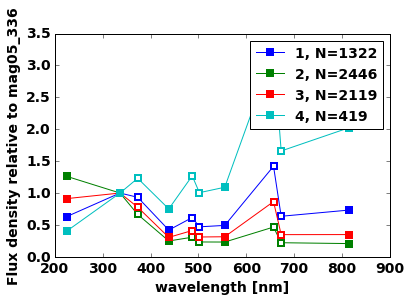

In [13]:
cluster_all_colours(alldat[allgood],photlist,'mag05_336')

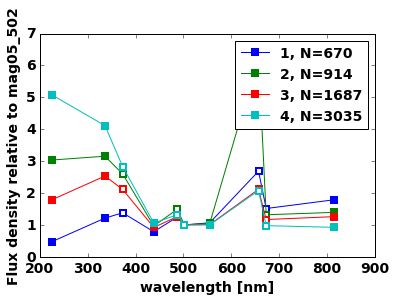

In [14]:
cluster_all_colours(alldat[allgood],photlist,'mag05_502')

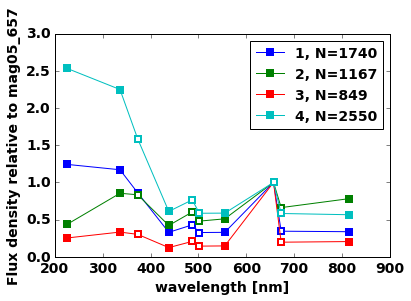

In [15]:
cluster_all_colours(alldat[allgood],photlist,'mag05_657')

In [36]:
print "test {}".format("Hello")

test Hello


In [ ]:
    col_dat = np.array([alldat[p][allgood]-alldat[anchor][allgood] for p in photlist]).T
    for nclust in range(3,9):
        print "N: {}".format(nclust)
        km_new = KMeans(nclust, init='random')
        km_new.fit(col_dat)
        labels = km_new.labels_
        newcens = km_new.cluster_centers_
        score = metrics.silhouette_score(col_dat, labels)
        sample_score = silhouette_samples(col_dat, labels)

In [37]:
col_dat = np.array([alldat[p][allgood]-alldat[anchor][allgood] for p in photlist]).T

NameError: name 'anchor' is not defined

In [ ]:
km_new = KMeans(3, init='random')

In [ ]:
km_new.fit(col_dat)

In [ ]:
labels = km_new.labels_

In [ ]:
score = metrics.silhouette_score(col_dat, labels)

In [ ]:
score